# Kinetic Parameter Estimation

Author: Vibhav Dabadghao
<br>
April 7, 2021

## Introduction

Determination of reaction kinetics accurately is critical to develop chemical processes that are safe, tractable and scalable. Often, little information about the kinetics, mechanisms and species is available. Experiments at the lab and pilot scale are designed to estimate them. Experiments are expensive to run, especially in the pharmaceutical industry. Hence, it is imperative to develop methods to derive maximum information from each experiment. Some examples of such experiments are spectroscopy (ultraviolet, infrared, near-infrared, Raman etc.), chromatography (high-performance liquid chromatography, ultra-performance liquid chromatography etc.) and calorimetry. In most cases, the goal is to determine kinetic parameters which would set the stage for generating reliable simulation models for a larger chemical process involving the same chemistry.

This tutorial will focus on the developing a systematic framework for parameter estimation using experiments involving spectroscopic measurements. In general, the experiment involves a light source, a mono- or poly-chromator which isolates light of chosen wavelengths, the reaction mixture and a detector. The light passes through the monochromator from which only the light of the chosen wavelength emerges. It is then passed through the reaction mixture which absorbs a fraction of the light. The detector measures the reduction in the intensity of light. The experiment relies on the property that a given species has a fixed [absorbance](https://en.wikipedia.org/wiki/Absorbance) (the amount of radiation absorbed by a substance). In other words, a species in isolation or in a mixture would have the same absorbance. Further, the absorbance increases/decreases as the species concentration increases/decreases.

### Tutorial Content

In this tutorial, we will shed some light (pun intended) on a simple yet effective way to analyze spectral measurements through 3D interactive plots, and learn how to disambiguate these measurements to tell us what's happening in the reaction mixture. After analyzing these measurements, we will show how to estimate and validate concentrations of all species in the reaction mixture. Finally, we set up a simple least-squares problem to estimate the kinetic parameters.

We will be using data provided to me by my colleague in the Department of Chemical Engineering. As mentioned before, these are spectroscopic measurements and will be elaborated upon further in a few paragraphs.

We will cover the following topics in this tutorial
- [Problem statement](http://localhost:8888/notebooks/kinetic-parameter-estimation-tutorial.ipynb#Problem-Statement)
- [Understanding measurement data](http://localhost:8888/notebooks/kinetic-parameter-estimation-tutorial.ipynb#Spectroscopic-Data)
- [Visualizing the spectral measurements](http://localhost:8888/notebooks/kinetic-parameter-estimation-tutorial.ipynb#Visualizing-the-spectral-data)
- [Obtaining concentration profiles](http://localhost:8888/notebooks/kinetic-parameter-estimation-tutorial.ipynb#Obtaining-concentration-profiles)
- [Estimating kinetic parameters](http://localhost:8888/notebooks/kinetic-parameter-estimation-tutorial.ipynb#Estimating-Kinetic-Parameters)

## Problem Statement

We consider a reaction mixture containing three species: A, B and C. The reaction mechanism is

$$ A \xrightarrow{k_1} B \xrightarrow{k_2} C $$

where $k_1$ and $k_2$ are the rate constants which we would like to estimate. The rate of consumption and production of the species is given by the following set of differential equations.

\begin{align}
\frac{dc_A}{dt} &= -k_1 c_A \\
\frac{dc_B}{dt} &= k_1 c_A - k_2 c_B \\
\frac{dc_C}{dt} &= k_2 c_B
\end{align}

where $c_i$ is the concentration of species $i$. Our goal is to estimate the rate constants from the spectral data. The true rate constants are given to be $k_1 = 1.5$ and $k_2 = 0.2$ min$^{-1}$ (we will compare these with our estimation). At the start of the reaction, only 0.01 mol/L of A is present in the reaction mixture.

## Spectroscopic Data

The data required for this tutorial can be downloaded from the following links:
1. [Spectral measurements, `Dij.txt`](https://drive.google.com/file/d/1sI_BbRM7rapSOfDFULHTtD4evIZ2Qn9Y/view?usp=sharing)
2. [True absorbances of species, `S_true.csv`](https://drive.google.com/file/d/1XRmnNsoQ14qe37sMjZ47GSO7KmdBmr_1/view?usp=sharing)
3. [True concentratrion profiles, `Z_true.csv`](https://drive.google.com/file/d/1bmYoJqgnYWFDApT7ZHaZgZH-WzQUX--E/view?usp=sharing)


The spectroscopic data ($D$) can be decomposed to give concentration profiles ($C$) and absorbance of species ($S$). [Beer-Lambert's law](https://en.wikipedia.org/wiki/Beer%E2%80%93Lambert_law) provides physical meaning to this decomposition in the following way ($E$ indicates the measurement error).
$$ D = C S^\top + E $$

With true spectroscopic data, the Beer's law equation $D = C S^\top$ takes the following form.

<img src=https://i.imgur.com/ZM3f17R.png width="800">

It is important to appreciate that the measurements can be considered to be independent of the sampling time, and concentrations at each time point can be estimated independently. In other words, we will be solving for one row of the $C$ matrix at a time. The $D$ and $S$ data is available to us from text and csv files respectively. The file `Dij.txt` containts measurements $D$ for a range of wavelengths at every sampling time. We read the data in to a pandas dataframe and look at the first few entries.

In [1]:
import numpy as np
import pandas as pd
import requests
from io import StringIO

D_url = 'https://drive.google.com/file/d/1sI_BbRM7rapSOfDFULHTtD4evIZ2Qn9Y/view?usp=sharing'
file_id = D_url.split('/')[-2]
download_url = 'https://drive.google.com/uc?export=download&id=' + file_id
url = requests.get(download_url).text
D_txt_raw = StringIO(url)

df = pd.read_csv(D_txt_raw, delimiter='\s+', header=None, names=['time', 'wavelength', 'Dij'])
df.head(10)

,time,wavelength,Dij
0,0.0,180.0,0.010880
1,0.0,180.5,0.011728
2,0.0,181.0,0.012619
3,0.0,181.5,0.013197
4,0.0,182.0,0.013931
5,0.0,182.5,0.014949
6,0.0,183.0,0.015589
7,0.0,183.5,0.016420
8,0.0,184.0,0.017275
9,0.0,184.5,0.018178


## Visualizing the spectral data

We want to visualize this data to hopefully gain some insight about the concentration profiles. First, we extract the wavelengths and sampling times from `df`.

In [2]:
wavelength = df['wavelength'].unique()
time = df['time'].unique()

nwavelength = len(wavelength)
ntime = len(time)

print(f'The number of sampling times are {ntime} from t = {time[0]} to t = {time[-1]} mins.')
print(f'The number of distinct wavelengths are {nwavelength} from w = {wavelength[0]} to w = {wavelength[-1]} nm')

The number of sampling times are 501 from t = 0.0 to t = 10.0 mins.
The number of distinct wavelengths are 100 from w = 180.0 to w = 229.5 nm


Next, we compartmentalize the data into groups, where each group contains measurements for every wavelength at a given sampling time. In other words, each row in the above $D$ matrix is a group. Finally, we plot the spectral data for all sampling times. Running the code block below will produce an interactive 3D plot. You can orient it in various ways to have a better understanding of the measurements.

<IPython.core.display.Javascript object>


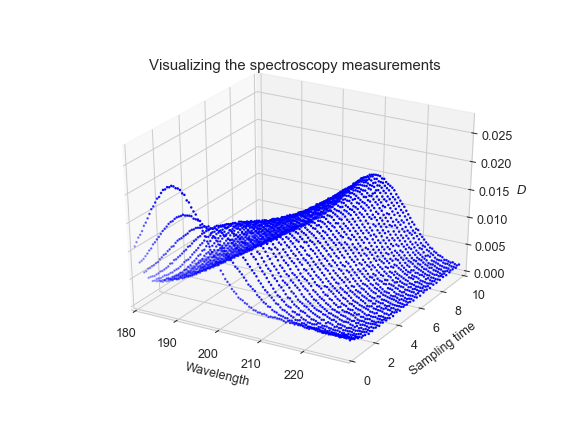

In [3]:
dij_bytime = df.groupby(by=['time'])

%matplotlib notebook
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
sns.set_style('whitegrid')

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

D_max = df['Dij'].max() + df['Dij'].std()
ax.set_xlim([wavelength.min(), wavelength.max()])
ax.set_ylim([time.min(), time.max()])
ax.set_zlim([0, D_max])
ax.set_xlabel('Wavelength')
ax.set_ylabel('Sampling time')
ax.set_zlabel(r'$D$')
ax.set_title(f'Visualizing the spectroscopy measurements')

for i, t in enumerate(time[::15]):
    X, Y = np.meshgrid(wavelength, t)
    Z = dij_bytime.get_group(t)['Dij'].values.reshape(-1, 1)
    ax.scatter(X, Y, Z, '.', s=1, c='b')
    fig.canvas.draw()

fig.show()

The above graph seems to suggest _three different peaks_ forming as the reaction progresses. This is expected since we have three reating species. We visualize the progression in 2D:

<IPython.core.display.Javascript object>


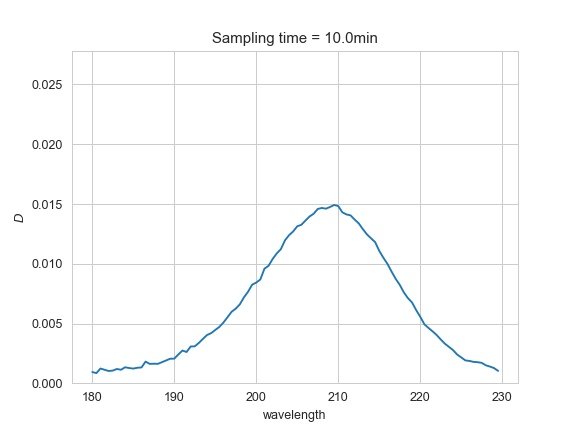

In [4]:
fig, ax = plt.subplots()

D_max = df['Dij'].max() + df['Dij'].std()
ax.set_ylim([0, D_max])
ax.set_ylabel(r'$D$')

for t in time[::10]:
    group = dij_bytime.get_group(t)
    [artist.remove() for artist in ax.lines]
    ax.set_title(f'Sampling time = {t}min')
    group.plot(x='wavelength', y='Dij', ax=ax, legend=False)
    fig.canvas.draw()

fig.show()

### Absorbance Data

Next, we read in the absorbance data ($S$). It contains absorbances of our components at different wavelengths. The variable `components` stores the component names.

In [5]:
S_url = 'https://drive.google.com/file/d/1XRmnNsoQ14qe37sMjZ47GSO7KmdBmr_1/view?usp=sharing'
file_id = S_url.split('/')[-2]
download_url = 'https://drive.google.com/uc?export=download&id=' + file_id
url = requests.get(download_url).text
S_csv_raw = StringIO(url)

s_df = pd.read_csv(S_csv_raw, delimiter=',', header=0)
s_df.rename(columns={'Unnamed: 0': 'wavelength'}, inplace=True)
s_df.set_index('wavelength', inplace=True)

components = list(s_df.columns)

s_df.head(10)

,B,C,A
wavelength,,,
180.0,0.132734,0.099914,1.097788
180.5,0.139873,0.099928,1.169196
181.0,0.148344,0.099965,1.243701
181.5,0.158335,0.100030,1.320820
182.0,0.170045,0.100130,1.399983
182.5,0.183688,0.100273,1.480540
183.0,0.199490,0.100471,1.561766
183.5,0.217684,0.100738,1.642865
184.0,0.238505,0.101092,1.722992


## Obtaining concentration profiles

For each sampling time, we apply ordinary least squares to solve the Beer's law equation for $C$. This is done using a linear model built using sci-kit learn where we minimize the least squares objective $\displaystyle \sum_i (D_{ij} - C_{jk} S^\top_{ki})^2  \hspace{0.5cm} \forall j$, where $i, \, j,$ and $k$ are indices for wavelength, time and species respectively. The concentration profiles obtained are as follows.

In [6]:
from sklearn import linear_model
model = linear_model.LinearRegression()

c = np.empty([ntime, 3])
s = s_df[components].values

for i, t in enumerate(time):
    dij = dij_bytime.get_group(t)['Dij'].values
    model.fit(s, dij)
    c[i] = model.coef_

pd.DataFrame(c, columns=components)

,B,C,A
0,-0.000024,-0.000004,0.010004
1,0.000295,-0.000003,0.009709
2,0.000583,-0.000013,0.009410
3,0.000876,-0.000005,0.009153
4,0.001129,-0.000008,0.008870
...,...,...,...
496,0.001623,0.008386,-0.000024
497,0.001613,0.008440,-0.000008
498,0.001559,0.008397,-0.000003
499,0.001551,0.008451,0.000039


We compare these concentrations with the true concentration profiles. These are retrieved from the file `Z_true.csv`.

In [7]:
Z_url = 'https://drive.google.com/file/d/1bmYoJqgnYWFDApT7ZHaZgZH-WzQUX--E/view?usp=sharing'
file_id = Z_url.split('/')[-2]
download_url = 'https://drive.google.com/uc?export=download&id=' + file_id
url = requests.get(download_url).text
Z_csv_raw = StringIO(url)

c_true = pd.read_csv(Z_csv_raw, delimiter=',', header=0)
c_true.rename(columns={'Unnamed: 0': 'time'}, inplace=True)
c_true.head()

,time,A,B,C
0,0.000000,0.010000,0.000000,0.000000e+00
1,0.015505,0.009770,0.000230,3.582524e-07
2,0.064495,0.009078,0.000916,6.016247e-06
3,0.100000,0.008607,0.001379,1.418143e-05
4,0.115505,0.008409,0.001572,1.875865e-05


Finally, we plot the estimated and true concentrations and compare them qualitatively. We observe that the two profiles virtually sit on top of each other for all three species. We also note that the peak concentration of species B occurs at t = 1.54 mins.

<IPython.core.display.Javascript object>


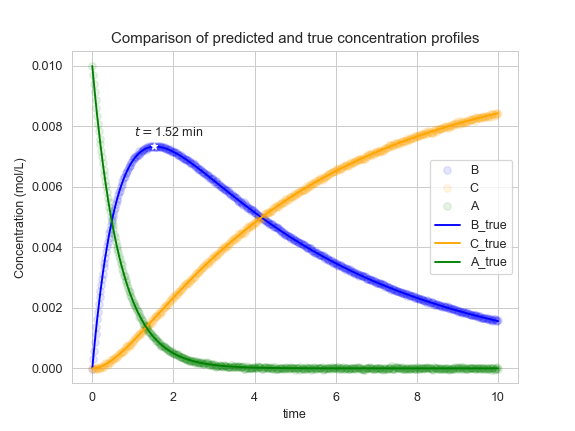

Text(1.02, 0.0077, '$t =$1.52 min')

In [8]:
fig, ax = plt.subplots()

ax.set_ylabel('Concentration (mol/L)')
ax.set_title('Comparison of predicted and true concentration profiles')
ax.set_ylim([0 - 0.0005, 0.01 + 0.0005])
colors = ['blue', 'orange', 'green']
ax.set_prop_cycle(color=colors)

ax.plot(time, c, linestyle='', marker='o', alpha=0.1)
c_true.plot(x='time', y=components, ax=ax)

true_comps = [comp + '_true' for comp in components]
ax.legend(components + true_comps)

# Annotate the peak for species B
bmax = np.argmax(c[:, 0])
ax.plot(time[bmax], c[bmax, 0], color='white', marker='*', markersize=5)
ax.annotate(f"$t =${time[bmax]} min", (time[bmax], c[bmax, 0]), (time[bmax]-0.5, 0.0077), xycoords='data')

We refer back to the absorbance profiles and now we are able to confirm that the three "peaks" in absorbances correspond to the times at which the three species were most abundant in the reaction mixture.

<IPython.core.display.Javascript object>


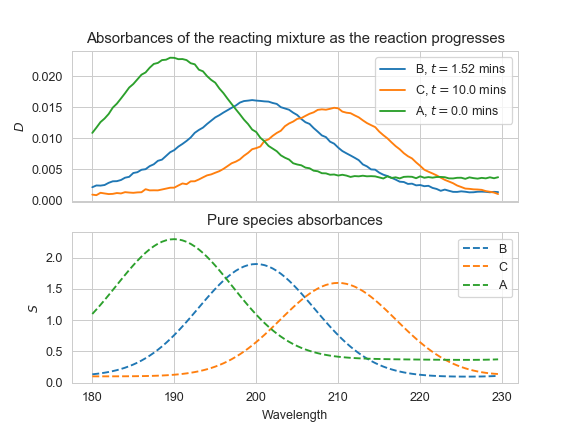

In [9]:
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)

colors = ['blue', 'orange', 'green']

ax1.set_ylabel(r'$D$')
ax1.set_title(f'Absorbances of the reacting mixture as the reaction progresses')
legend_text = '{}, $t = ${} mins'

max_idxs = [bmax, -1, 0]  # for B, C and A respectively

for t in time[max_idxs]:
    group = dij_bytime.get_group(t)
    group.plot(x='wavelength', y='Dij', ax=ax1, legend=False)

ax1.legend([legend_text.format(comp, t) for comp, t in zip(components, time[max_idxs])])

ax2.plot(wavelength, s, '--')
ax2.set_title(f'Pure species absorbances')
ax2.set_ylabel(r'$S$')
ax2.set_xlabel('Wavelength')
ax2.legend(components)

## Estimating Kinetic Parameters

Now that we have concentration profiles, we can generate $dC/dt$ data at each time point. This is done using the first order approximation of the derivative from Taylor's series. 
$$ \frac{dC}{dt_i} \approx \frac{c_{i+1} - c_i}{t_{i+1} - t_i} $$

Using `np.diff` in the following way applies the forward difference formula at all but the last sampling time.

In [10]:
dcdt = np.array([np.diff(c[:, i]) / np.diff(time) for i in range(len(components))]).T
dcdt.shape

(500, 3)

The last step is to fit a linear model as per the set of differential equations described above to estimate the parameters $k_1$ and $k_2$. We use the equation $\frac{dc_B}{dt} = k_1 c_A - k_2 c_B$ and apply 5-fold cross validation by shuffling the data and fit linear models using sci-kit learn. Finally, we select the model with the best test score.

In [11]:
from sklearn.model_selection import KFold

n_splits = 5
kf = KFold(n_splits=n_splits, shuffle=True)

# skip the last row since dcdt is not defined; columns [2, 0] correspond to species A and B respectively.
X = c[:-1, [2, 0]]
test_scores = np.zeros(n_splits)
coefs = []

for i, (train, test) in enumerate(kf.split(X)):
    model.fit(X[train], dcdt[train, 0])
    test_scores[i] = model.score(X[test], dcdt[test, 0])
    coefs.append(model.coef_)

# choose the model with the best test score
best_score = np.argmax(test_scores)
k = coefs[best_score]
k[1] *= -1  # sign in front of k2 is negative.
print(r'The kinetic rate constants are: k1 = {:.2f} and k2 = {:.2f} per min.'.format(*k))

The kinetic rate constants are: k1 = 1.49 and k2 = 0.21 per min.


The estimates are in good agreement with the given rate constants.

In [12]:
k_true = np.array([1.50, 0.2])
error = (k - k_true) / k_true * 100
print(r'The precentage error in the estimated rate constants is k1: {:.2f}% and k2: {:.2f}%.'.format(*error))

The precentage error in the estimated rate constants is k1: -0.99% and k2: 3.01%.


## Summary and References

In this tutorial, we demonstrated a systematic way of estimating kinetic parameters as well as concentration profiles from spectroscopic data. We used ordinary least squares to estimate the parameters using a linear model. This procedure can be easily extended to nonlinear reaction mechanisms by replacing the model with linear coefficients with a nonlinear function. It can also be extended to estimate concentration profiles, kinetic constants and unknown absorbances simultaneously by integrating the reaction model with the least squares objective function and solving the system as a constrained dynamic optimization problem. As such, this work provides a framework for parameter estimation from experimental data. It can be extended it to other reaction systems and sets the stage for building reliable simulation models for the chemical process.
More information about concepts covered in the tutorial can be found in the following links.

1. [Absorbance](https://en.wikipedia.org/wiki/Absorbance)
2. [Beer-Lambert's Law](https://en.wikipedia.org/wiki/Beer%E2%80%93Lambert_law)
3. [Interactive 3D plotting](https://matplotlib.org/2.0.2/mpl_toolkits/mplot3d/tutorial.html)